This is not the latest version, the latest version is in the hard drive. I will update it afterwards

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
import keras 
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, BatchNormalization, Activation, MaxPooling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import GlorotUniform
from PIL import Image


2024-12-18 09:07:52.673801: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-18 09:07:52.699321: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-18 09:07:52.699349: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-18 09:07:52.700172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-18 09:07:52.704804: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# Set the environment variable to specify which GPU to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
#labels_df = pd.read_csv("/home/elahed/users/elahe/Automatic-Data-Collector/output_town04/scaled_filtered_control_commands.csv")
#images_directory = '/home/elahed/users/elahe/Automatic-Data-Collector/output_town04/front_rgb/'
labels_df = pd.read_csv("/home/elahed/users/elahe/project_with_aws/output_front/augmented_scaled_steering_data.csv")
images_directory = '/home/elahed/users/elahe/project_with_aws/output_front/augment/'
labels = []
image_path = []
Image_and_label = []
# Iterate through the rows of the DataFrame
for index, row in labels_df.iterrows():
    labels.append([row['Steering']])
    image_path.append(os.path.join(images_directory, row['Image_Fname']))  # Replace with the actual column name
    #Image_and_label.append([os.path.join(images_directory, row['Image_Fname']+'.png'),row['Steering'],row['Throttle'],row['Brake']])

In [4]:
len(labels)

75214

In [5]:
len(image_path)

75214

In [6]:
print(labels)

[[-0.842894375324249], [0.842894375324249], [-0.910610496997833], [0.910610496997833], [-0.891366422176361], [0.891366422176361], [-0.918736040592194], [0.918736040592194], [-0.810523986816406], [0.810523986816406], [-0.801967740058899], [0.801967740058899], [-0.815046429634094], [0.815046429634094], [-0.943904519081116], [0.943904519081116], [-0.829629242420196], [0.829629242420196], [-0.815295100212097], [0.815295100212097], [-0.936198830604553], [0.936198830604553], [-0.820551455020904], [0.820551455020904], [-0.806955814361572], [0.806955814361572], [-0.816531121730804], [0.816531121730804], [-0.944426476955413], [0.944426476955413], [-0.828039109706878], [0.828039109706878], [-0.808024406433105], [0.808024406433105], [-0.922617256641388], [0.922617256641388], [-0.804367363452911], [0.804367363452911], [-0.918022334575653], [0.918022334575653], [-0.805862724781036], [0.805862724781036], [-0.907363831996918], [0.907363831996918], [-0.900232553482056], [0.900232553482056], [-0.916440

In [7]:
print(labels[0])

[-0.842894375324249]


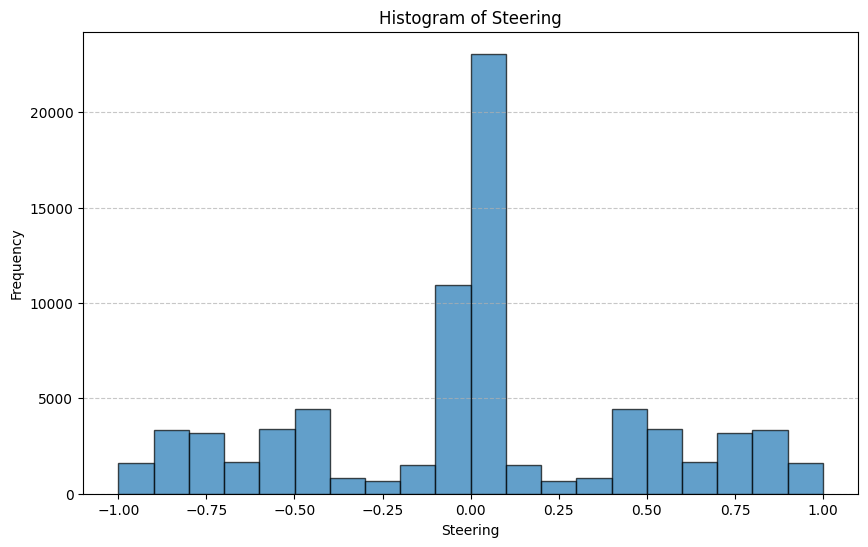

In [4]:
import matplotlib.pyplot as plt

# Plot the histogram for the 'Steering' column
column_name = 'Steering'

plt.figure(figsize=(10, 6))
plt.hist(labels_df[column_name], bins=20, edgecolor='black', alpha=0.7)
plt.title(f"Histogram of {column_name}")
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [5]:
def flipping(img, steering):
    flip_image = cv2.flip(img,1)
    flip_steering = steering*-1.0
    return flip_image, flip_steering

def brightness(img,steering):
    bright_limit = (-0.5, 0.15)
    brightness_multiplier = 1.0 + np.random.uniform(low=bright_limit[0], high=bright_limit[1])
    image_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    image_hsv[:,:,2] = image_hsv[:,:,2] * brightness_multiplier
    bright_image = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    return bright_image , steering

In [6]:
class My_Custom_Generator1(keras.utils.Sequence):
    def __init__(self, image_filenames, labels, batch_size, augment, crop_coords=None):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.augment = augment
        self.crop_coords = crop_coords

    def __len__(self):
        return (np.floor(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx * self.batch_size : (idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx + 1) * self.batch_size]
        inputs = []
        outputs = []

        for filename, labels in zip(batch_x, batch_y):
            try:
                # Load the image
                img = Image.open(filename)
                
                # Convert to RGB to ensure consistent channels
                img = img.convert("RGB")
                
                # Apply cropping if specified
                if self.crop_coords:
                    left, top, right, bottom = self.crop_coords
                else:
                    left, top, right, bottom = 0, 255, 448, 448  # Default cropping values
                img = img.crop((left, top, right, bottom))

                # Convert to NumPy array and resize
                img = np.array(img)
                img_resized = cv2.resize(img, (160, 160))
                inputs.append(img_resized)
                outputs.append(labels[0])

                # Apply augmentations if specified
                if self.augment[0] == 'Flip':
                    image, steer = flipping(img_resized, labels[0])
                    inputs.append(image)
                    outputs.append(steer)

                if self.augment[1] == 'bright':
                    image, steer = brightness(img_resized, labels[0])
                    inputs.append(image)
                    outputs.append(steer)

            except Exception as e:
                print(f"Skipping file {filename} due to error: {e}")

        # Ensure inputs are consistent in shape
        inputs_final = np.array(inputs).astype("float32") / 255.0
        outputs = np.array(outputs).astype("float32")
        return inputs_final, outputs


In [7]:
batch_size = 32
#X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(image_path,labels, test_size=0.1,shuffle=True)
X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(image_path,labels, test_size=0.1,shuffle=False)
train_generator = My_Custom_Generator1(X_train_data, y_train_data, batch_size,augment =["no","no"] )
valid_generator = My_Custom_Generator1(X_valid_data, y_valid_data, batch_size,augment =["no","no"] )

In [8]:
print(len(X_valid_data))

7522


In [12]:
#### for test ####
'''
batch_size = 32
# Combine labels and class_labels for consistent splitting
train_generator = My_Custom_Generator1(image_path, labels, batch_size,augment =["no","bright"] )
'''

'\nbatch_size = 32\n# Combine labels and class_labels for consistent splitting\ntrain_generator = My_Custom_Generator1(image_path, labels, batch_size,augment =["no","bright"] )\n'

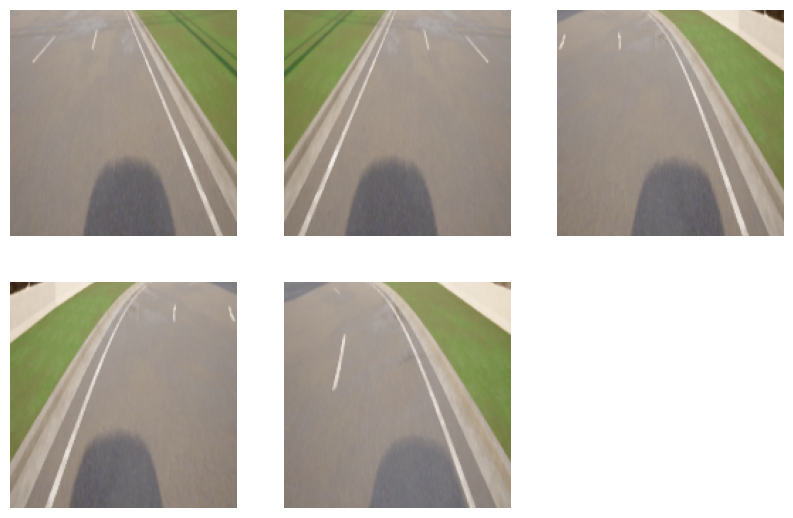

In [9]:
# Generate and plot 5 augmented images
plt.figure(figsize=(10, 10))
for i in range(5):
    augmented_image = train_generator[0][0][i]
    plt.subplot(3, 3, i+1)
    plt.imshow(augmented_image)
    plt.axis('off')
plt.show()

In [14]:
len(X_train_data)

67692

In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Model

def get_resnet_model():
    # Input Layer
    inputs_img = Input(shape=(160, 160, 3), name='input_image')

    # ResNet-50 Backbone (Pre-trained on ImageNet)
    # Include the top=False to exclude the final classification head.
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs_img, input_shape=(160, 160, 3))

    # Freeze initial ResNet layers (optional, for transfer learning)
    for layer in base_model.layers[:143]:  # Fine-tune from block4 onwards
        layer.trainable = False

    # Add Custom Layers for Regression
    x = base_model.output
    x = GlobalAveragePooling2D(name='global_avg_pool')(x)  # Global average pooling for reduced dimensionality
    x = Dense(1024, activation='relu', name='fc1')(x)
    x = Dropout(rate=0.2, name='dropout1')(x)
    x = Dense(512, activation='relu', name='fc2')(x)
    x = Dropout(rate=0.2, name='dropout2')(x)
    x = Dense(256, activation='relu', name='fc3')(x)
    x = Dense(100, activation='relu', name='fc4')(x)
    x = Dense(50, activation='relu', name='fc5')(x)
    x = Dense(10, activation='relu', name='fc6')(x)

    # Output Layer for Steering Prediction
    output = Dense(1, activation='tanh', name='fc_output')(x)

    # Define the Model
    model = Model(inputs=inputs_img, outputs=output)
    return model

# Create and summarize the model
IL_model = get_resnet_model()
IL_model.summary()


2024-12-17 21:20:37.148911: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 21:20:37.172738: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-17 21:20:37.173002: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_image[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [16]:
from tensorflow.keras.utils import plot_model
# Plot the model architecture
plot_model(IL_model, to_file='model.pdf', show_shapes=True, show_layer_names=True)

In [17]:
from tensorflow.keras.callbacks import ModelCheckpoint
# Define the checkpoint directory and file format
#checkpoint_path = 'IL_model_22_all_plus_3000_retrain_turn_only_then_back_into_lane_ckpt.10-0.003.h5'
#IL_model.load_weights(checkpoint_path)

In [18]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.96)
optimizer_mine = keras.optimizers.Adam(learning_rate=lr_schedule)

2024-12-17 21:20:50.162951: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


In [19]:
# Specify the directory where TensorBoard logs will be stored
log_dir = "town06_all_bs32_resnet_all_town_tanh"

# Create TensorBoard callback
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=0)

# Checkpoint to save the best weights
model_ckpt_name = "IL_model_all_bs32_resnet_all_town_tanh"
checkpoint = ModelCheckpoint(model_ckpt_name + '_best.h5',
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min')

# Early stopping with restore_best_weights enabled
patience = 10
earlystop = EarlyStopping(monitor='val_loss', 
                          min_delta=0, 
                          patience=patience, 
                          verbose=1, 
                          mode='min', 
                          restore_best_weights=True)

# Combine all callbacks
callbacks = [checkpoint, earlystop, tensorboard_callback]

# Compile the model
IL_model.compile(optimizer=optimizer_mine, loss='MSE')

# Train the model
train_hist = IL_model.fit(train_generator,  
                          steps_per_epoch=len(X_train_data) // batch_size, 
                          epochs=500, 
                          validation_data=valid_generator,
                          validation_steps=len(X_valid_data) // batch_size,
                          shuffle=True,
                          verbose=1, 
                          callbacks=callbacks#,
                          #use_multiprocessing=True,
                          #workers=8
                          )


Epoch 1/500


2024-12-17 21:20:56.510255: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-17 21:20:56.577115: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-12-17 21:21:00.180114: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f7d3a5082c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-12-17 21:21:00.180134: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-12-17 21:21:00.183426: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1734488460.243734 3954723 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2115/2115 [==============================] - ETA: 0s - loss: 0.0236
Epoch 1: val_loss improved from inf to 0.04129, saving model to IL_model_all_bs32_resnet_all_town_tanh_best.h5


/home/elahed/anaconda3/envs/active_inference/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2115/2115 [==============================] - 464s 215ms/step - loss: 0.0236 - val_loss: 0.0413
Epoch 2/500
2115/2115 [==============================] - ETA: 0s - loss: 0.0148
Epoch 2: val_loss improved from 0.04129 to 0.01136, saving model to IL_model_all_bs32_resnet_all_town_tanh_best.h5
2115/2115 [==============================] - 444s 210ms/step - loss: 0.0148 - val_loss: 0.0114
Epoch 3/500
2115/2115 [==============================] - ETA: 0s - loss: 0.0130
Epoch 3: val_loss did not improve from 0.01136
2115/2115 [==============================] - 444s 210ms/step - loss: 0.0130 - val_loss: 0.0116
Epoch 4/500
2115/2115 [==============================] - ETA: 0s - loss: 0.0121
Epoch 4: val_loss did not improve from 0.01136
2115/2115 [==============================] - 443s 209ms/step - loss: 0.0121 - val_loss: 0.0201
Epoch 5/500
2115/2115 [==============================] - ETA: 0s - loss: 0.0109
Epoch 5: val_loss did not improve from 0.01136
2115/2115 [==============================] -

In [20]:
### check for problematic images ###
'''
import os
file_path = "/home/elahed/users/elahe/project_with_aws/all_mix/image_2024-05-17-53-46_00460551_augmented_flipped.png"
print(f"File exists: {os.path.exists(file_path)}")
'''


'\nimport os\nfile_path = "/home/elahed/users/elahe/project_with_aws/all_mix/image_2024-05-17-53-46_00460551_augmented_flipped.png"\nprint(f"File exists: {os.path.exists(file_path)}")\n'

In [21]:
### check for problematc images ###s
'''
from PIL import Image

try:
    with Image.open(file_path) as img:
        img.verify()  # Check if the file is corrupted
        print(f"Image {file_path} is valid")
except Exception as e:
    print(f"Pillow error: {e}")
'''

'\nfrom PIL import Image\n\ntry:\n    with Image.open(file_path) as img:\n        img.verify()  # Check if the file is corrupted\n        print(f"Image {file_path} is valid")\nexcept Exception as e:\n    print(f"Pillow error: {e}")\n'

In [22]:
### repair images ###
'''
import os
from PIL import Image

def repair_image(file_path, output_folder=None):
    """
    Attempt to repair and re-save a corrupted image.
    :param file_path: Path to the image file.
    :param output_folder: Optional folder to save repaired images. If None, overwrite the original file.
    """
    try:
        with Image.open(file_path) as img:
            img = img.convert("RGB")  # Ensure a valid format
            if output_folder:
                # Save to a new location
                os.makedirs(output_folder, exist_ok=True)
                output_path = os.path.join(output_folder, os.path.basename(file_path))
                img.save(output_path)
                print(f"Repaired and saved: {output_path}")
            else:
                # Overwrite the original file
                img.save(file_path)
                print(f"Repaired: {file_path}")
    except Exception as e:
        print(f"Failed to repair {file_path}: {e}")

def batch_repair_images(folder, output_folder=None):
    """
    Repair all corrupt images in a folder.
    :param folder: Path to the folder containing images.
    :param output_folder: Optional folder to save repaired images. If None, overwrite the originals.
    """
    for file_name in os.listdir(folder):
        file_path = os.path.join(folder, file_name)
        if os.path.isfile(file_path):
            try:
                with Image.open(file_path) as img:
                    img.verify()  # Check for corruption
            except Exception as e:
                print(f"Attempting to repair {file_path}: {e}")
                repair_image(file_path, output_folder)

# Set the folder containing your images
image_folder = "/home/elahed/users/elahe/project_with_aws/all_mix"
#output_folder = "/path/to/repaired_images"  # Optional: Set to None to overwrite originals

# Repair all corrupted images
#batch_repair_images(image_folder, output_folder)
batch_repair_images(image_folder)
'''

'\nimport os\nfrom PIL import Image\n\ndef repair_image(file_path, output_folder=None):\n    """\n    Attempt to repair and re-save a corrupted image.\n    :param file_path: Path to the image file.\n    :param output_folder: Optional folder to save repaired images. If None, overwrite the original file.\n    """\n    try:\n        with Image.open(file_path) as img:\n            img = img.convert("RGB")  # Ensure a valid format\n            if output_folder:\n                # Save to a new location\n                os.makedirs(output_folder, exist_ok=True)\n                output_path = os.path.join(output_folder, os.path.basename(file_path))\n                img.save(output_path)\n                print(f"Repaired and saved: {output_path}")\n            else:\n                # Overwrite the original file\n                img.save(file_path)\n                print(f"Repaired: {file_path}")\n    except Exception as e:\n        print(f"Failed to repair {file_path}: {e}")\n\ndef batch_repa

In [21]:
IL_model.save('IL_town06_steer_bs32_resnet_all_town_tanh.keras')
IL_model.save('IL_town06_steer_bs32_resnet_all_town_tanh.h5')

#### Evaluation

In [9]:
from tensorflow.keras.models import load_model
# Load the trained model
model = load_model('IL_town06_steer_bs32_resnet_all_town.h5')

# Confirm the model is loaded successfully
model.summary()


2024-12-18 09:08:14.825463: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-18 09:08:14.857088: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-18 09:08:14.857379: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_image (InputLayer)    [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 166, 166, 3)          0         ['input_image[0][0]']         
                                                                                                  
 conv1_conv (Conv2D)         (None, 80, 80, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 80, 80, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                          

In [ ]:
# Predict in batches
#predicted_values = model.predict(train_generator, verbose=1)

2024-12-17 09:22:36.177449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-17 09:22:36.222555: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


 626/8437 [=>............................] - ETA: 26:55

KeyboardInterrupt: 

2024-12-18 09:08:21.395017: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-12-18 09:08:21.451030: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


1/1 [==============================] - 0s 15ms/step


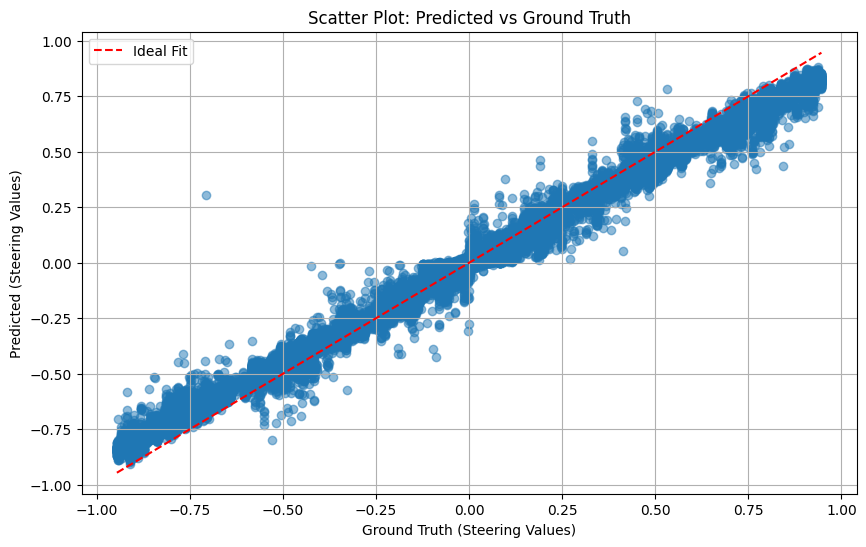

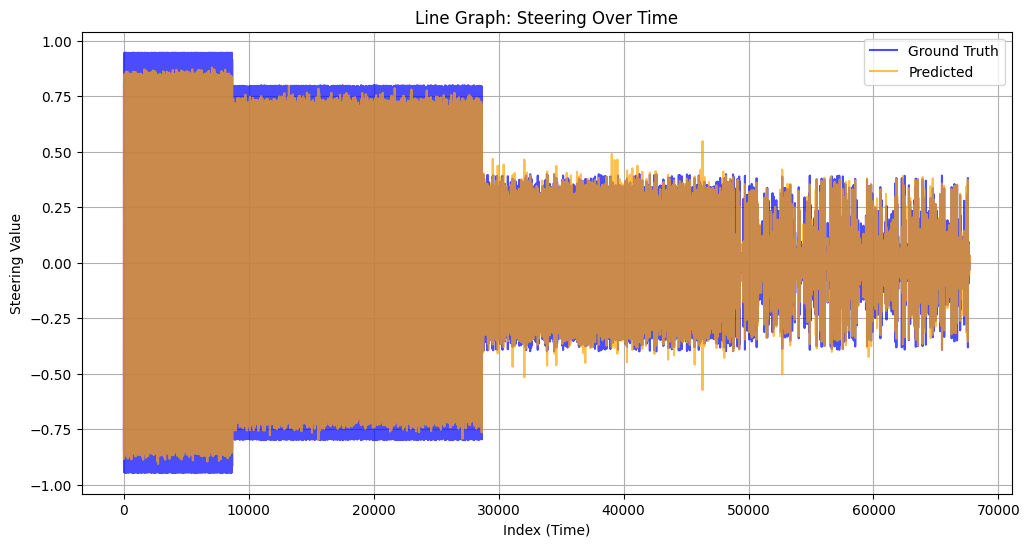

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have a trained model `model`
# Get predictions and ground truth from the validation generator
predicted_values = []
ground_truth_values = []

for i in range(len(train_generator)):
    X_valid, y_valid = train_generator[i]
    predictions = model.predict(X_valid)
    
    # Append predictions and ground truth
    predicted_values.extend(predictions.flatten())  # Flatten to a 1D list
    ground_truth_values.extend(y_valid.flatten())

# Convert to NumPy arrays for consistency
predicted_values = np.array(predicted_values)
ground_truth_values = np.array(ground_truth_values)

# 1. Scatter Plot: Predicted vs Ground Truth
plt.figure(figsize=(10, 6))
plt.scatter(ground_truth_values, predicted_values, alpha=0.5)
plt.plot([ground_truth_values.min(), ground_truth_values.max()], 
         [ground_truth_values.min(), ground_truth_values.max()], 
         color='red', linestyle='--', label='Ideal Fit')
plt.xlabel("Ground Truth (Steering Values)")
plt.ylabel("Predicted (Steering Values)")
plt.title("Scatter Plot: Predicted vs Ground Truth")
plt.legend()
plt.grid()
plt.show()

# 2. Line Graph: Steering Over Time
plt.figure(figsize=(12, 6))
plt.plot(ground_truth_values, label="Ground Truth", color="blue", alpha=0.7)
plt.plot(predicted_values, label="Predicted", color="orange", alpha=0.7)
plt.xlabel("Index (Time)")
plt.ylabel("Steering Value")
plt.title("Line Graph: Steering Over Time")
plt.legend()
plt.grid()
plt.show()


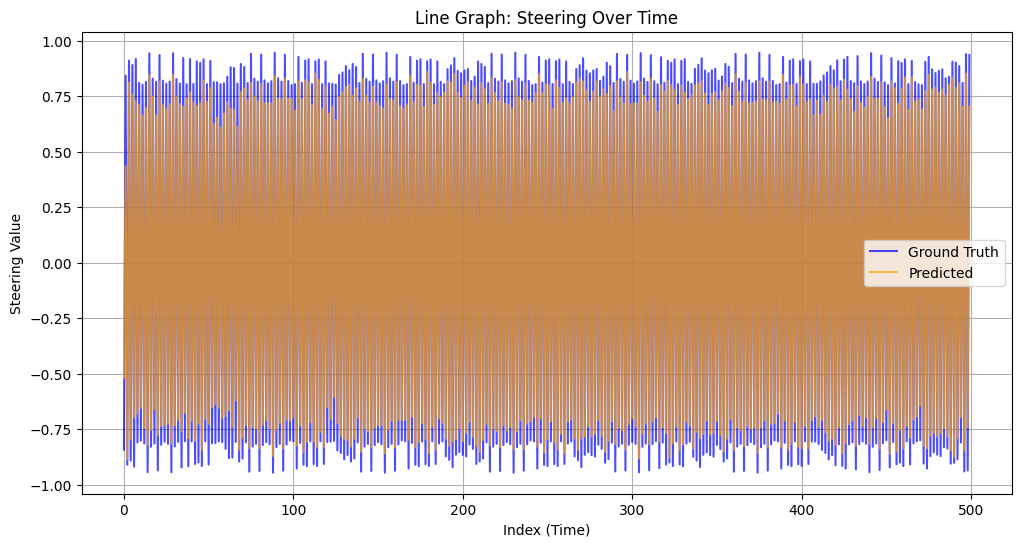

In [12]:
# 2. Line Graph: Steering Over Time
plt.figure(figsize=(12, 6))
plt.plot(ground_truth_values[0:500], label="Ground Truth", color="blue", alpha=0.7)
plt.plot(predicted_values[0:500], label="Predicted", color="orange", alpha=0.7)
plt.xlabel("Index (Time)")
plt.ylabel("Steering Value")
plt.title("Line Graph: Steering Over Time")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Store predictions in the dataset
labels_df['predicted_steering']= predicted_values[:len(image_path)]

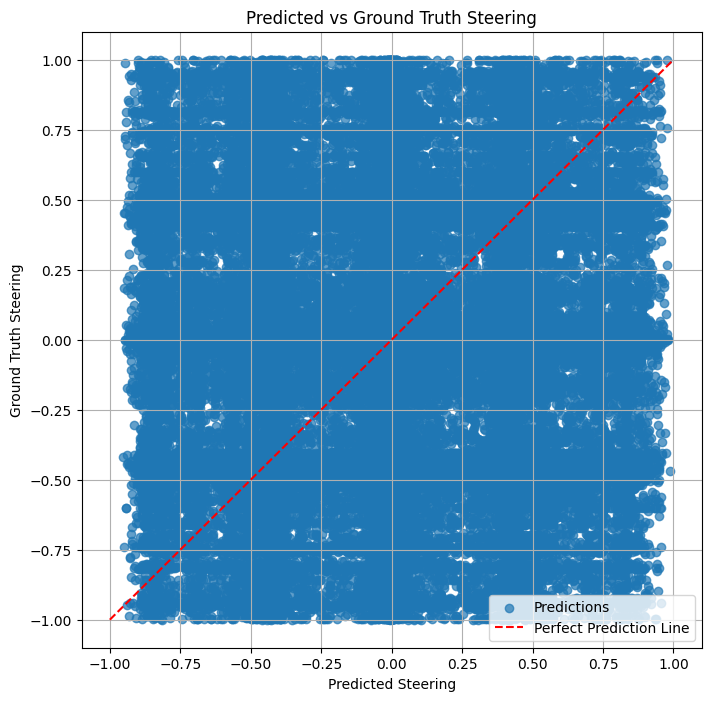

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


##### Scatter Plot: Predicted vs Ground Truth #####

ground_truth = labels_df['Steering']
predicted = labels_df['predicted_steering']  # Replace with your predicted data

plt.figure(figsize=(8, 8))
plt.scatter(predicted, ground_truth, alpha=0.7, label="Predictions")
plt.plot([-1, 1], [-1, 1], 'r--', label="Perfect Prediction Line")  # Diagonal line
plt.xlabel("Predicted Steering")
plt.ylabel("Ground Truth Steering")
plt.title("Predicted vs Ground Truth Steering")
plt.legend()
plt.grid()
plt.show()

In [ ]:
print(len(ground_truth))
print(len(predicted))

84386
84386


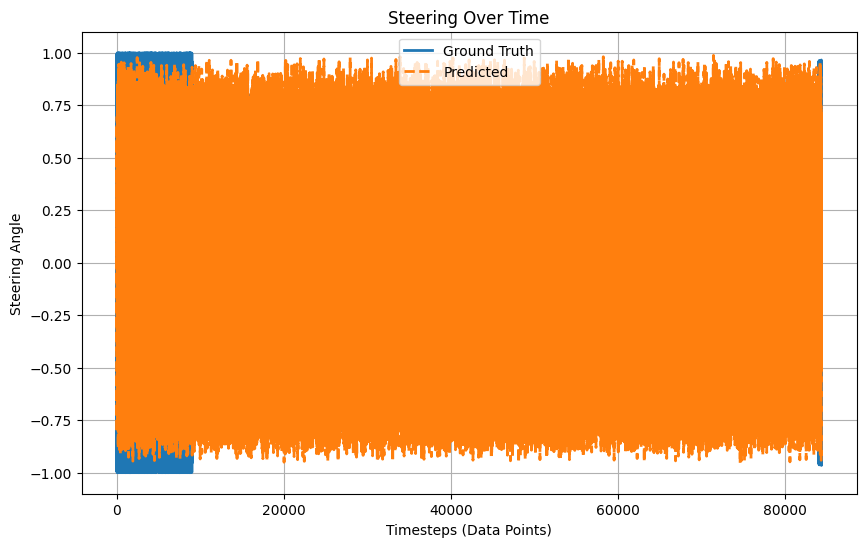

In [ ]:
##### Line Graph: Steering Over Time ######

timesteps = np.arange(len(ground_truth))  
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ground_truth, label="Ground Truth", linewidth=2)
plt.plot(timesteps, predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time")
plt.legend()
plt.grid()
plt.show()

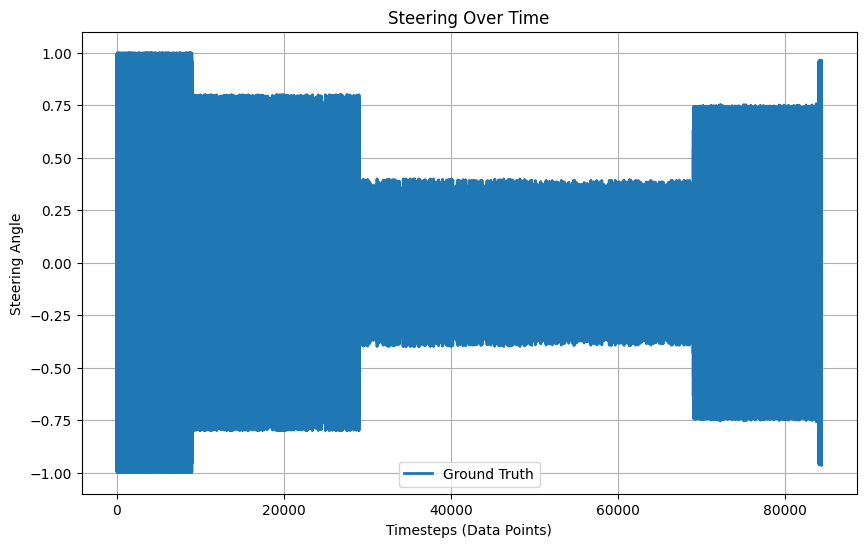

In [ ]:
timesteps = np.arange(len(ground_truth))  
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ground_truth, label="Ground Truth", linewidth=2)
# plt.plot(timesteps, predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time")
plt.legend()
plt.grid()
plt.show()

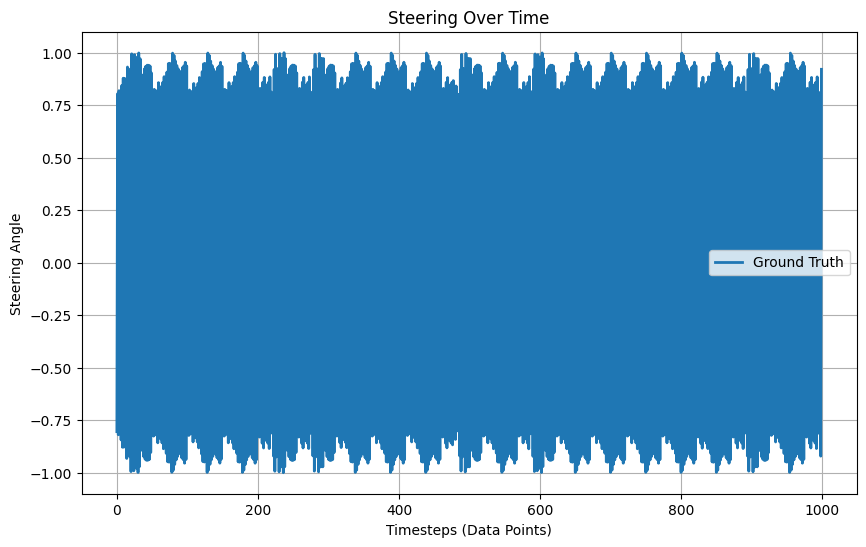

In [ ]:
timesteps = np.arange(len(ground_truth[0:1000]))  
plt.figure(figsize=(10, 6))
plt.plot(timesteps, ground_truth[0:1000], label="Ground Truth", linewidth=2)
# plt.plot(timesteps, predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time")
plt.legend()
plt.grid()
plt.show()

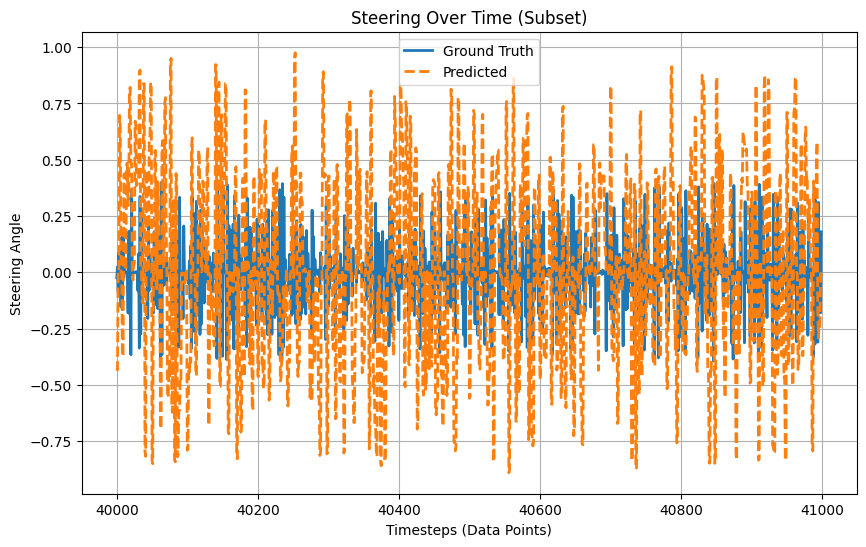

In [ ]:
# Define the range of timesteps you want to plot
start = 40000  # Starting index
end = 41000    # Ending index

# Slice the data for the specific range
subset_ground_truth = ground_truth[start:end]
subset_predicted = predicted[start:end]
subset_timesteps = timesteps[start:end]

# Plot the subset of data
plt.figure(figsize=(10, 6))
plt.plot(subset_timesteps, subset_ground_truth, label="Ground Truth", linewidth=2)
plt.plot(subset_timesteps, subset_predicted, label="Predicted", linestyle="dashed", linewidth=2)
plt.xlabel("Timesteps (Data Points)")
plt.ylabel("Steering Angle")
plt.title("Steering Over Time (Subset)")
plt.legend()
plt.grid()
plt.show()
